A notebook for investigating the behaviours of SC_UME under different scenarios.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kmod
import kgof
import kgof.goftest as gof
# submodules
from kmod import data, density, kernel, util
from kmod import mctest as mct
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

In [2]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Optimization of SC_UME

In [4]:
def rot2d_matrix(angle):
    import math
    r = np.array( [[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]] )
    return r

def rot2d_cov(angle, cov):
    R = rot2d_matrix(angle)
    return np.dot(np.dot(R, cov), R.T)

In [5]:
means = np.array([[-1.0, 1], [1, 1], [-1, -1], [1, -1]])*5
base_cov = np.array([[5.0, 0], [0, 0.5]])

# 4 isotropic covariance matrices in 2d
covr = np.tile(base_cov, [4, 1, 1])
covq = np.tile(rot2d_cov(np.pi/5.0, base_cov), [4, 1, 1])
covp = np.tile(rot2d_cov(np.pi/2.0, base_cov), [4, 1, 1])

p = density.GaussianMixture(means, covp)
q = density.GaussianMixture(means, covq)
r = density.GaussianMixture(means, covr)

In [63]:
# sample
n =1000
seed = 37
dsp, dsq, dsr = [P.get_datasource() for P in [p, q, r]]
datp, datq, datr = [ds.sample(n, seed=seed) for ds in [dsp, dsq, dsr]]
X, Y, Z = [D.data() for D in [datp, datq, datr]]

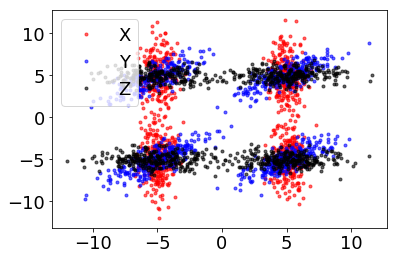

In [64]:
def plot2d_data(X, Y, Z):
    # see the samples in 2D
#     plt.figure(figsize=(8, 5))
    a = 0.6
    plt.plot(X[:, 0], X[:, 1], 'r.', label='X', alpha=a)
    plt.plot(Y[:, 0], Y[:, 1], 'b.', label='Y', alpha=a)
    plt.plot(Z[:, 0], Z[:, 1], 'k.', label='Z', alpha=a)
    plt.legend()
plot2d_data(X, Y, Z)

In [70]:
tr_proportion = 0.5
# split the data into training/test sets
[(datptr, datpte), (datqtr, datqte), (datrtr, datrte)] = \
    [D.split_tr_te(tr_proportion=tr_proportion, seed=seed+82) for D in [datp, datq, datr]]
Xtr, Ytr, Ztr = [D.data() for D in [datptr, datqtr, datrtr]]

In [108]:
# number of test locations J 
J = 20

Xyztr = np.vstack((Xtr, Ytr, Ztr))
# initialize optimization parameters.
# Initialize the Gaussian widths with the median heuristic
medxyz = util.meddistance(Xyztr, subsample=1000)
gwidth0 = medxyz**2

# pick a subset of points in the training set for V, W
V0 = util.subsample_rows(Xyztr, J, seed=seed+3)

# optimization options
opt_options = {
    'max_iter': 100,
    'reg': 1e-5,
    'tol_fun': 1e-7,
    'locs_bounds_frac': 100,
    'gwidth_lb': 0.1**2,
    'gwidth_ub': 10,
}
V_opt, gw2_opt, opt_result = mct.SC_GaussUME.optimize_3sample_criterion(
    datptr, datqtr, datrtr, V0, gwidth0, **opt_options)    
k_opt = kernel.KGauss(gw2_opt)
opt_result

{'fun': -0.33877468662311855,
 'hess_inv': <41x41 LbfgsInvHessProduct with dtype=float64>,
 'jac': array([-1.45119802e-04, -1.70228118e-05,  4.69440385e-06,  1.47433934e-05,
        -6.78447286e-07,  2.95862518e-06, -1.71725826e-05,  9.67496916e-06,
         7.10950657e-06, -3.59177733e-06, -5.92390689e-06,  1.65374993e-06,
        -2.70975209e-06, -7.56243664e-06, -1.01542542e-05, -1.32083604e-05,
         8.85204471e-06, -1.03132182e-06,  5.55596126e-06, -1.67982567e-05,
         3.66444787e-06,  2.72843776e-05, -3.84089223e-06, -5.52788319e-06,
         3.18283612e-06, -1.19682080e-06,  7.18374281e-06,  5.54921534e-06,
        -4.29909292e-06,  3.31473616e-06,  1.98131419e-06,  3.31037500e-06,
         1.41562311e-05,  1.24513101e-06,  9.92135608e-06, -1.43642671e-06,
        -1.58962880e-06, -5.50787900e-07,  1.68837909e-06, -2.94741786e-06,
        -6.05888980e-06]),
 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'nfev': 69,
 'nit': 54,
 'status': 0,
 'success': 

In [109]:
# construct a UME test
alpha = 0.05
scume_opt3 = mct.SC_UME(datpte, datqte, k_opt, k_opt, V_opt, V_opt,
        alpha=alpha)
scume_opt3_result = scume_opt3.perform_test(datrte)
scume_opt3_result

{'alpha': 0.05,
 'h0_rejected': True,
 'pvalue': 7.59434369222604e-16,
 'test_stat': 0.030672143289922082,
 'time_secs': 0.0028641223907470703}

Opt. Gaussian width (not squared): 1.4822


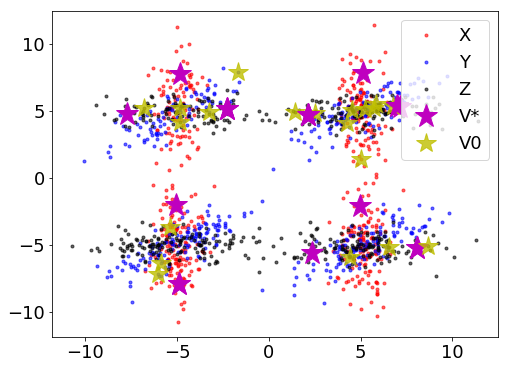

In [110]:
# plot the optimized locations
plt.figure(figsize=(8, 6))
plot2d_data(Xtr, Ytr, Ztr)
for j in range(J):
    vj = V_opt[j, :]
    v0j = V0[j, :]
    plt.plot(vj[0], vj[1], 'm*', markersize=24, label='V*')
    plt.plot(v0j[0], v0j[1], 'y*', markersize=20, label='V0', alpha=0.8)
    if j ==0:
        plt.legend()
print('Opt. Gaussian width (not squared): {:.5g}'.format(gw2_opt**0.5))